In [12]:
import pandas as pd
import numpy as np

In [13]:
df=pd.read_excel("fibreshot_clean.xlsx",sheet_name="in")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Columns: 1024 entries, fibreshottime to 1023
dtypes: float64(1023), object(1)
memory usage: 7.8+ MB


In [14]:
df.head(7)

,fibreshottime,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,22:30:07.994000,0.840229,0.887397,0.809196,0.253604,0.181111,0.303052,0.326150,0.398227,1.864811,...,0.267354,0.262241,0.277209,0.322208,0.202257,0.230640,0.243941,0.278307,0.266927,0.187142
1,22:30:08.358000,13.201060,0.987356,1.680790,0.608987,0.313534,0.364520,0.468044,1.348178,1.738608,...,0.574497,0.401139,0.514664,1.017531,0.452417,0.445572,0.747572,0.599552,0.459695,0.575436
2,22:30:08.723000,15.846101,0.477794,0.782222,0.261701,0.250232,0.217795,0.331494,0.601364,0.775977,...,0.311389,0.255630,0.483783,0.412810,0.229129,0.260424,0.331060,0.261470,0.206276,0.307389
3,22:30:09.087000,8.801699,0.304165,0.265573,0.300158,0.250317,0.256215,0.271231,0.197571,0.586284,...,0.293426,0.231230,0.304196,0.330548,0.148427,0.200270,0.214486,0.187417,0.166375,0.223437
4,22:31:04.689000,0.875403,1.213887,0.522335,0.128527,1.213887,1.213887,1.213887,1.213887,1.213887,...,0.229811,0.104014,0.307832,0.197380,1.065338,0.150758,0.231836,0.251376,0.183446,0.143143
5,22:31:05.155000,0.381827,0.530506,0.501788,0.093663,0.530506,0.530506,0.530506,0.530506,0.530506,...,0.121140,0.111821,0.122595,0.154178,0.473621,0.195770,0.136407,0.091063,0.243345,0.285898
6,22:31:05.620000,0.301669,0.419706,0.526050,0.413151,0.419706,0.419706,0.419706,0.419706,0.419706,...,0.097954,0.069040,0.084209,0.153983,0.230355,0.113764,0.204174,0.154844,0.156816,0.181943


In [15]:
# Find number columns that are fully empty
empty_col_count = (df.isna().sum() == len(df)).sum()
empty_col_count

np.int64(0)

In [16]:
# Basic preprocessing
sensor_columns = [col for col in df.columns if col != 'fibreshottime']
df[sensor_columns] = df[sensor_columns].astype(float)

Visualization

In [17]:
import matplotlib.pyplot as plt

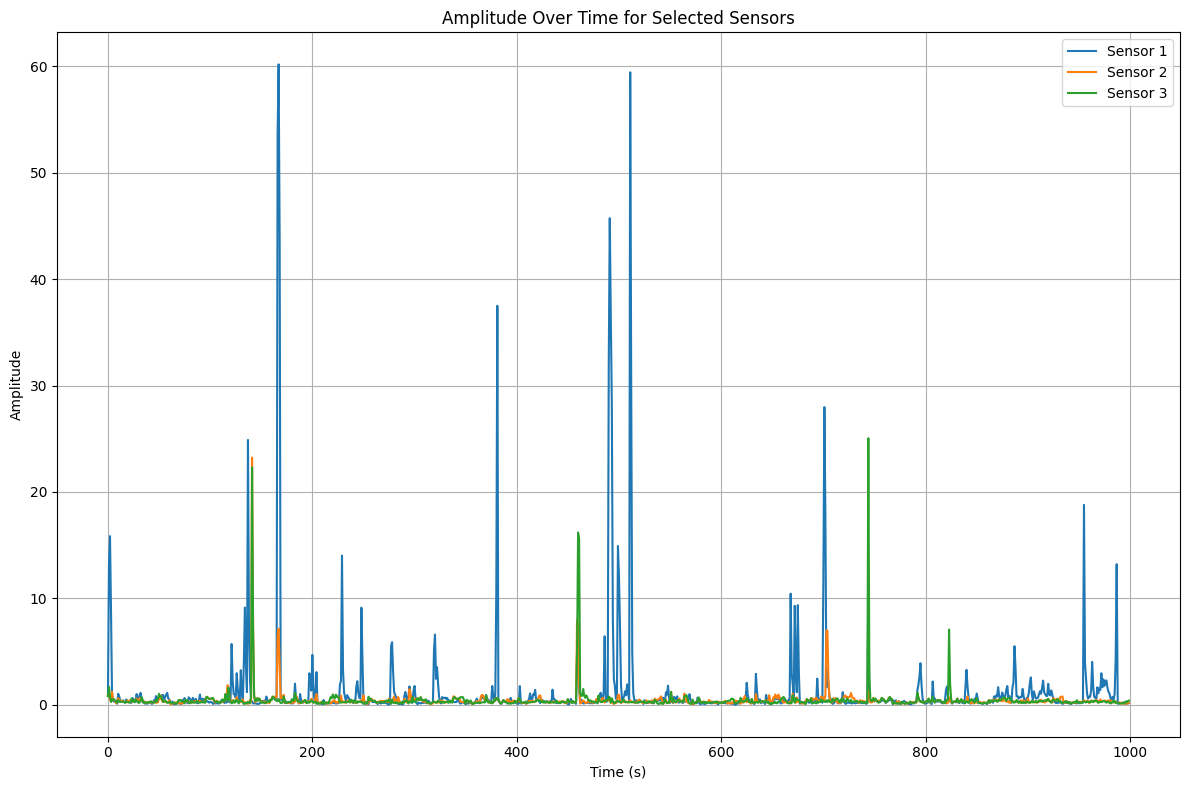

In [18]:
if pd.api.types.is_datetime64_any_dtype(df['fibreshottime']) or df['fibreshottime'].dtype == 'object':
    time_seconds = range(len(df))
else:
    time_seconds = df['fibreshottime'].values
sensors = [1, 2, 3]
plt.figure(figsize=(12, 8))

for sensor in sensors:
    plt.plot(time_seconds, df.iloc[:, sensor], label=f'Sensor {sensor}')

plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Amplitude Over Time for Selected Sensors')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [19]:
from scipy.interpolate import interp1d

# Convert time to seconds
original_time = df['fibreshottime'].apply(lambda x: x.hour * 3600 + x.minute * 60 + x.second).values
sensor_columns = [col for col in df.columns if col != 'fibreshottime']
new_time = np.linspace(original_time.min(), original_time.max(), len(original_time) * 100)

# Interpolate all sensors at once
interp_funcs = {sensor: interp1d(original_time, df[sensor], kind='linear', fill_value='extrapolate') 
                for sensor in sensor_columns}
upsampled_data = {sensor: func(new_time) for sensor, func in interp_funcs.items()}

# Create a  upsampled DataFrame
upsampled_df = pd.DataFrame({'fibreshottime': new_time})
upsampled_df = pd.concat([upsampled_df, pd.DataFrame(upsampled_data)], axis=1)

Feature Selection

In [20]:
sensor_columns = [col for col in df.columns if col != 'fibreshottime']
averages = df[sensor_columns].mean()


selected_sensors = [col for col in sensor_columns if averages[col] > 0.5]

Labeling

In [21]:
sensor_columns = [col for col in df.columns if col != 'fibreshottime']
averages = df[sensor_columns].mean()

labels = ['anomaly' if avg > 0.5 else 'noise' for avg in averages]

transposed_df = df[sensor_columns].T
transposed_df['label'] = labels

Modeling and Classification

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler

In [23]:
sensor_columns = [col for col in df.columns if col != 'fibreshottime']
X = df[sensor_columns].values
y = ['anomaly' if df[col].mean() > 0.5 else 'noise' for col in sensor_columns]

# Scale features
scaler = StandardScaler()
X = scaler.fit_transform(X.T)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)


y_pred = model.predict(X_test)

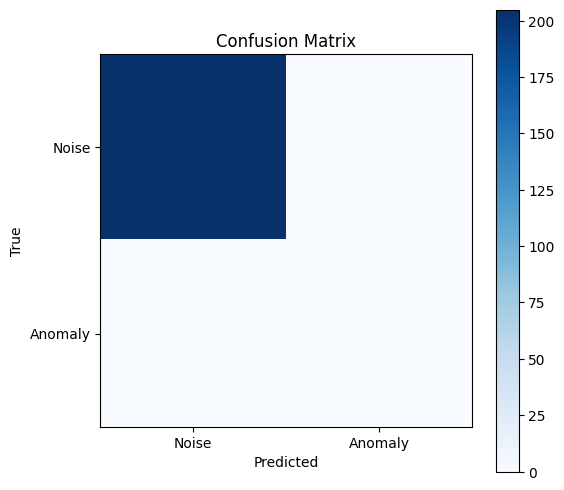

In [25]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=['noise', 'anomaly'])
plt.figure(figsize=(6, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xticks([0, 1], ['Noise', 'Anomaly'])
plt.yticks([0, 1], ['Noise', 'Anomaly'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
# ROC Curve
y_prob = model.predict_proba(X_test)[:, 1]
y_true = (np.array(y_test) == 'anomaly').astype(int)
if np.sum(y_true) > 0:
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()
else:
    print("No positive 'anomaly' samples in y_test. ROC curve cannot be computed.")

No positive 'anomaly' samples in y_test. ROC curve cannot be computed.


In [27]:
from scipy.signal import savgol_filter
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score



# Apply Savgol filter for denoising
sensor_columns = [col for col in df.columns if col != 'fibreshottime']
for sensor in sensor_columns:
    df[sensor] = savgol_filter(df[sensor], window_length=11, polyorder=2)

# Prepare data
X = df[sensor_columns].values
y = ['anomaly' if df[col].mean() > 0.5 else 'noise' for col in sensor_columns]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X.T, y, test_size=0.2, random_state=42)

# MLP Classifier
model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=500)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 1.00
